In [1]:
#导入所需包
from influxdb import InfluxDBClient
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft,fftpack
import datetime

In [2]:
# 连接influxDB数据库
client = InfluxDBClient(host="10.9.141.15",database="ems_collector")

In [3]:
# 查询获取数据
query = "select * from ems_collector_machine_pac_energy where mdmname= 'JQPTENG2CSS1CS_0090AA0HDNALFG' order by time desc limit 51840"
result = client.query(query)

In [4]:
# 数据转为DataFrame
for i in result:
    dic = {}
    for a,x in enumerate(i):
        dic[len(i)-a] = x
df = pd.DataFrame(dic).T

In [8]:
#转换日期格式，并提取日期列并排序
df['time'] = pd.to_datetime(df['time'])
df['time'] = df['time'].apply(lambda x:x + datetime.timedelta(hours=8))
df['date'] = df['time'].apply(lambda x:x.date())
df = df.sort_values(by='time')

In [9]:
df.columns

Index(['PowerfactorA', 'PowerfactorB', 'PowerfactorC', 'TotalPowerFactor',
       'UnbalanceCurrent', 'UnbalanceVoltage', 'a_current', 'ab_voltage',
       'activeEnergy', 'apparentEnergy', 'b_current', 'bc_voltage',
       'c_current', 'ca_voltage', 'ip', 'mdmname', 'time', 'totalActivePower',
       'totalApparentPower', 'totalReactivePower', 'date', 'state'],
      dtype='object')

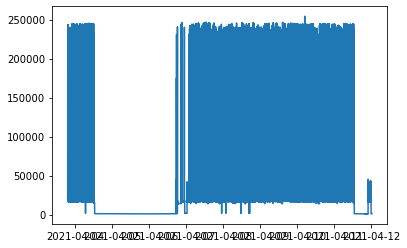

In [10]:
# 总趋势可视化
plt.plot(df.time,df.totalActivePower)

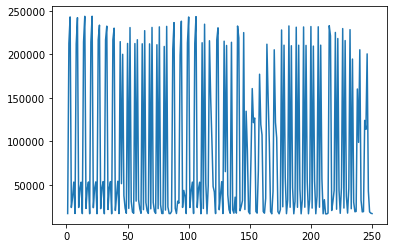

In [11]:
# 频域分析区域截取
plt.plot(df.totalActivePower[:250])

In [12]:
# 频域变换及计算频域坐标
power = df['totalActivePower'][:250]
p_f = fft(power)
freq = fftpack.fftfreq(len(power),10)

<ipython-input-12-38566364b3a6>:3: DeprecationWarning: Using scipy.fft as a function is deprecated and will be removed in SciPy 1.5.0, use scipy.fft.fft instead.
  p_f = fft(power)


In [13]:
# 计算复数模并归一化（频幅）
# 计算复数角度（频相）
f = np.abs(p_f)/len(p_f)
a = np.angle(p_f)

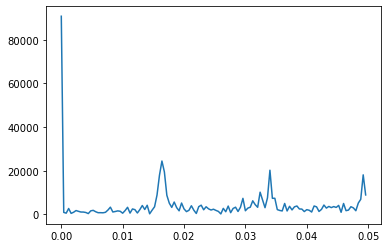

In [14]:
plt.plot(freq[:int(len(f)/2)],f[:int(len(f)/2)])

In [15]:
# 获取幅值前四的特征
s = sorted(f[:int(len(f)/2)],reverse=True)
for i in range(4):
    t = s[i]
    print(t)
    idx = f[:int(len(f)/2)].tolist().index(t)
    print(freq[idx])

90753.76847999998
0.0
24458.12722133017
0.0164
20248.51191125945
0.034
19484.119855192243
0.016800000000000002


In [33]:
# 最大幅值还原
# 直流分量 = 0特征
# 其余特征幅值 需 *2
s[0]+2*s[1]+2*s[2]+2*s[3]

219135.28645556374

In [16]:
# 探索出的4种小波模式
temp1 = [17386.73, 212157.0, 242799.8, 24338.17, 28674.7, 53283.59]#, 17468.05]
temp2 = [16171.49, 230334.4, 25060.32, 208406.5, 58799.04, 17026.47]#]15885.0,
temp3 = [17519.39, 101440.1, 124881.1, 234148.3, 23403.87, 17381.73]#, 22053.1]
temp4 = [17717.71, 218951.4, 113707.4, 115971.1, 46747.31, 37218.69]

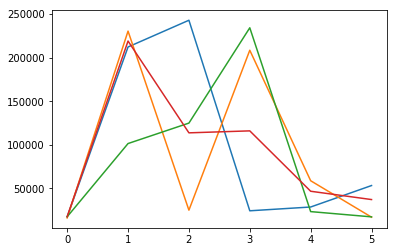

In [37]:
# 可视化四种循环能耗模式
plt.plot(temp1)
plt.plot(temp2)
plt.plot(temp3)
plt.plot(temp4)

In [17]:
# correlate互相关根据下述定义计算
# c_{av}[k] = sum_n a[n+k] * conj(v[n])
power = df.totalActivePower.tolist()
co1 = []
co2 = []
co3 = []
co4 = []
for i in range(len(power)-6):
    co1.append(np.correlate(temp1, power[i:i+6], mode='valid').item())

for i in range(len(power)-6):
    co2.append(np.correlate(temp2, power[i:i+6], mode='valid').item())

for i in range(len(power)-6):
    co3.append(np.correlate(temp3, power[i:i+6], mode='valid').item())

for i in range(len(power)-6):
    co4.append(np.correlate(temp4, power[i:i+6], mode='valid').item())

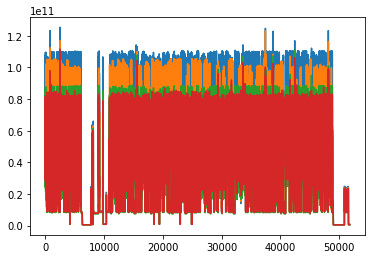

In [36]:
#可视化相关系数曲线
plt.plot(co1)
plt.plot(co2)
plt.plot(co3)
plt.plot(co4)

In [18]:
# 四种模式分别进行
# gama、gama2、gama3、gama4：四种线性对应的相关性超过阈值的点位区域
# mark：属于四种模式对应的曲线区域标记
c = 0
gama = []
for x, g in enumerate(co1):
    if g >= 0.9 * 10 ** 11:
        #print(x, x - c)
        if x - c >= 6:
            gama = gama + [1] * 6
            gama = gama + [0] * (x - c - 6)
        else:
            gama += [0] * (x - c)

            # print(len(gama))
        c = x
gama += [1] * (6)
gama += [0] * (len(power) - c - 6)

c = 0
gama2 = []
for x, g in enumerate(co2):
    if g >= 0.8 * 10 ** 11:
        #print(x, x - c)
        if x - c >= 6:
            gama2 = gama2 + [1] * 6
            gama2 = gama2 + [0] * (x - c - 6)
        else:
            gama2 += [0] * (x - c)

            # print(len(gama))
        c = x
gama2 += [1] * (6)
gama2 += [0] * (len(power) - c - 6)

c = 0
gama3 = []
for x, g in enumerate(co3):
    if g >= 0.8 * 10 ** 11:
        #print(x, x - c)
        if x - c >= 6:
            gama3 = gama3 + [1] * 6
            gama3 = gama3 + [0] * (x - c - 6)
        else:
            gama3 += [0] * (x - c)

            # print(len(gama))
        c = x
gama3 += [1] * (6)
gama3 += [0] * (len(power) - c - 6)

c = 0
gama4 = []
for x, g in enumerate(co4):
    if g >= 0.75 * 10 ** 11:
        #print(x, x - c)
        if x - c >= 6:
            gama4 = gama4 + [1] * 6
            gama4 = gama4 + [0] * (x - c - 6)
        else:
            gama4 += [0] * (x - c)

            # print(len(gama))
        c = x
gama4 += [1] * (6)
gama4 += [0] * (len(power) - c - 6)

mark = []
for i in range(len(gama)):
    if (gama[i] + gama2[i]+ gama3[i] + gama4[i]) >= 1:
        mark.append(1)
    else:
        mark.append(0)

mark = []
for i in range(len(gama)):
    if (gama[i] + gama2[i]+ gama3[i] + gama4[i]) >= 1:
        mark.append(1)
    else:
        mark.append(0)

<ipython-input-19-cf3719cbd69a>:14: MatplotlibDeprecationWarning: Since 3.2, the parameter *where* must have the same size as [0 1 2 ... 51837 51838 51839] in fill_betweenx(). This will become an error two minor releases later.
  ax2.fill_between(X,Y, mark, mark > Y, color='red', alpha=.2)


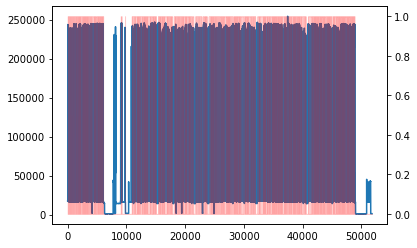

In [19]:
# 结果可视化
# 双纵轴曲线
# 区域填充
Y = [0] * 51840
X = range(51840)


fig,ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.plot(X, power)

ax2.fill_between(X,Y, mark, mark > Y, color='red', alpha=.2)

plt.show()

In [51]:
df['state'] = mark

In [56]:
# 获取加工状态时的能耗信息
energy = []
for x,i in enumerate(l):
    if i == 1:
        
        e = df['activeEnergy'][x+1+6]-df['activeEnergy'][x+1]
        energy.append(e)

(0, 5)

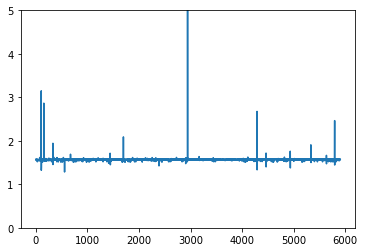

In [53]:
plt.plot(energy)
plt.ylim(0,5)

In [54]:
sum(energy)/len(energy)

1.585782706273632

In [55]:
(df['activeEnergy'].loc[51480]-df['activeEnergy'][1])/len(energy)

1.7194237816805018

In [21]:
# 导入PHM工具包，使用特征分解功能
from pyphmtool import feature_explore as fe

In [24]:
df_train = df[['PowerfactorA', 'PowerfactorB', 'PowerfactorC', 'TotalPowerFactor','totalActivePower',
              'UnbalanceCurrent', 'UnbalanceVoltage', 'a_current','b_current','c_current'
              ]]

In [25]:
train, label = fe.dataset_auto_label(corr_lsit=co1,data_set=df_train,seperate_threshold=0.9*10**11,slice_len=6)
train, label2 = fe.dataset_auto_label(corr_lsit=co2,data_set=df_train,seperate_threshold=0.8*10**11,slice_len=6)
train, label3 = fe.dataset_auto_label(corr_lsit=co3,data_set=df_train,seperate_threshold=0.8*10**11,slice_len=6)
train, label4 = fe.dataset_auto_label(corr_lsit=co4,data_set=df_train,seperate_threshold=0.75*10**11,slice_len=6)

In [49]:
# 训练集Label列
l = []
c = 0
for i in range(len(power)-8):
    if (label[i] + label2[i] + label3[i] + label4[i]) >= 1:
        if i-c >= 6:
            l.append(1)
            c = i
        else:
            l.append(0)
    else:
        l.append(0)

In [7]:
df = pd.read_csv("D:\Projects\AlgorithmLearning\data\ems_train.csv",index_col=0)

In [37]:
sample_N = 1000
pt = []
s=[]
while sample_N > 0:
    seek = np.random.randint(0,len(label))
    if seek in s:
        continue
    if label[seek] + label3[seek] + label2[seek] + label4[seek] >= 1:
        s.append(seek)
        pt.append(train[seek]['totalActivePower'].to_list())
        sample_N -= 1

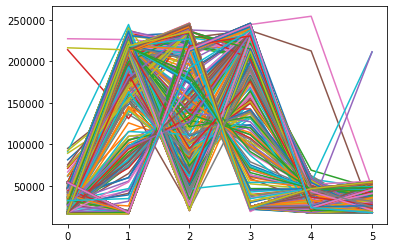

In [38]:
for item in pt:
    plt.plot(item)

In [39]:
cycle = np.array(pt)

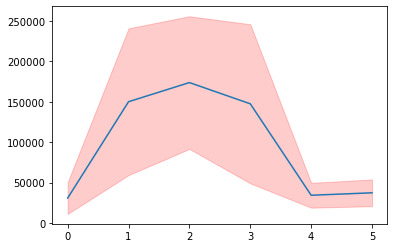

In [49]:
mean = cycle.mean(axis=0)
std = cycle.std(axis=0)
upl = mean+std
lol = mean-std

plt.plot(cycle.mean(axis = 0))
plt.fill_between(range(6),upl,lol,upl>lol,color= 'red',alpha=0.2)